# 장애인콜택시 대기시간 예측
## AI 3반 11조

## 1. 필요 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 필요하다고 판단되는 라이브러리를 추가하세요.

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns',None) # 모든 열 출력 

## 2. 데이터 불러오기

In [2]:
df = pd.read_pickle('data1.pkl')
df.head()

,Date,vehicle_c,receipt_c,boarding_c,waiting_time,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),weekday,month,season,year,holiday,wt_ma7,board_ratio,daily_vehicle
0,2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,63.0,28.0,9.07,Thursday,1,Winter,2015,1.0,23.200,0.903226,4.802817
1,2015-01-02,420,3158,2839,17.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,Friday,1,Winter,2015,0.0,20.200,0.898987,7.519048
2,2015-01-03,209,1648,1514,26.2,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,Saturday,1,Winter,2015,0.0,22.200,0.918689,7.885167
3,2015-01-04,196,1646,1526,24.5,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,Sunday,1,Winter,2015,0.0,22.775,0.927096,8.397959
4,2015-01-05,421,4250,3730,26.2,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,Monday,1,Winter,2015,0.0,23.460,0.877647,10.095012


In [3]:
# 데이터 칼럼명 변경
df.columns = ['Date', 'operation', 'receipt', 'boarding', 'waiting_time', 'fare',
       'distance', 'temp_max', 'temp_min', 'rain(mm)', 'humidity_max(%)',
       'humidity_min(%)', 'sunshine(MJ/m2)', 'weekday', 'month', 'season',
       'year', 'holiday', 'wt_ma7', 'board_ratio', 'operation_daily']
df.head(1)

,Date,operation,receipt,boarding,waiting_time,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),weekday,month,season,year,holiday,wt_ma7,board_ratio,operation_daily
0,2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,63.0,28.0,9.07,Thursday,1,Winter,2015,1.0,23.2,0.903226,4.802817


## 3. 파생변수 생성

1) weekday, month, season, year, holiday - 날짜 변수(요일, 월, 계절, 연도) 
2) holiday - 공휴일
3) wt_ma7 - 7일 이동평균 대기시간
4) board_ratio - 탑승률
5) operation_daily - 하루에 처리해야할 차량 접수건수 (접수건/차량운행수)
6) daily_temp_range 일교차 (temp_max - temp_min)
7) weekend - 주말 (범주형, 토일(1), 나머지(0))
8) taxi_base_rate - 택시 기본요금 (2012년 택시요금 2400원, 2013-2018년 기본요금 3000원, 2019년-3800원)
9) covid_yn - 코로나 유무 (2020년 전 0, 20년 후 1)
10) wt_ma3 - 3일 이동평균 대기시간
11) wt_ma5 - 5일 이동평균 대기시간
12) rain_yn - 강수유무

In [21]:
'''
# 1. 날짜 변수
'''
# df['Date'] = pd.to_datetime(df['Date'])
# df['weekday'] = df['Date'].dt.day_name()
# df['weekday'] = pd.Categorical(df['weekday'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
# df['month'] = df['Date'].dt.month
# df['season'] = np.where(df['month'].isin([3,4,5]), 'Spring',
#                            np.where(df['month'].isin([6,7,8]), 'Summer',
#                                     np.where(df['month'].isin([9,10,11]), 'Fall', 'Winter')))
# df['season'] = pd.Categorical(df['season'], categories=['Spring','Summer','Fall','Winter'])
                                     
# df['year'] = df['Date'].dt.year

'\n# 1. 날짜 변수\n'

In [22]:
'''
# 2. 공휴일
'''

# !pip install workalendar
# from workalendar.asia import SouthKorea

# cal = SouthKorea()
# holiday = pd.DataFrame()
# for y in range(2015, 2023) :
#     holiday = pd.concat([holiday, pd.DataFrame(cal.holidays(y))], axis = 0)

# holiday.columns = ['Date', 'holiday']
# holiday['Date'] = pd.to_datetime(holiday['Date'])
# holiday['holiday'] = 1
# holiday

# df = pd.merge(df, holiday, how = 'left')
# df = df.fillna({'holiday':0})
# df

'\n# 2. 공휴일\n'

In [23]:
'''
# 3. 7일 이동평균 대기시간
'''
# df['wt_ma7'] = df['waiting_time'].rolling( 7, min_periods = 1).mean()

'\n# 3. 7일 이동평균 대기시간\n'

In [24]:
'''
# 4. 탑승률
'''
# df['board_ratio'] = df['boarding_c'] / df['receipt_c']

'\n# 4. 탑승률\n'

In [25]:
'''
# 5. 하루에 처리해야할 차량 접수건수 (접수건/차량운행수)
'''
# df['daily_vehicle'] =  df['receipt_c'] / df['vehicle_c'] 

'\n# 5. 하루에 처리해야할 차량 접수건수 (접수건/차량운행수)\n'

In [4]:
'''
# 6. 일교차 (temp_max - temp_min)
'''

df['daily_temp_range'] = df['temp_max'] - df['temp_min']

In [5]:
'''
# 7. 주말
'''
def add_weekend_variable(weekday):
    if weekday < 5:          return 0
    else:  # 토요일(5)부터 일요일(6)까지는 1을 반환
        return 1

df['weekend'] = df['Date'].dt.weekday.apply(add_weekend_variable)

In [6]:
'''
# 8. 택시 기본요금
'''
def add_basic_fare(year):
    if 2012 == year:
        return 2400
    elif 2013 <= year <2019:
        return 3000
    elif year >= 2019:
        return 3800
    else:  # 나머지 경우는 0으로 처리
        return 0
    
df['taxi_base_rate'] = df['year'].apply(add_basic_fare)

In [7]:
'''
# 9. 코로나
'''
start_date = '2020-01-20'
end_date = '2023-05-11'

df['covid'] = 0  
df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date), 'covid'] = 1

In [8]:
'''
# 10. 3일 이동평균 대기시간
'''
df['wt_ma3'] = df['waiting_time'].rolling(3, min_periods = 1).mean()

In [9]:
'''
# 11. 5일 이동평균 대기시간
'''
df['wt_ma5'] = df['waiting_time'].rolling(5, min_periods = 1).mean()

In [10]:
'''
# 12. 강수유무
'''

def add_rain_yn(rain):
    if rain > 0:          return 1
    else:  
        return 0
    
df['rain_yn'] = df['rain(mm)'].apply(add_rain_yn)

## 4. EDA

In [13]:
# 숫자형 변수 분석
def eda_1_n(data, var, hue_var = ''):
    display(data[[var]].describe().T)

    if hue_var == '' :
        plt.figure(figsize = (15,10))
        plt.subplot(2,1,1)
        sns.histplot(data[var], kde = True, bins = 50)
        plt.grid()

        plt.subplot(2,1,2)
        sns.boxplot(x = data[var])
        plt.grid()
        plt.show()
    else :
        plt.figure(figsize = (15,5))
        plt.subplot(1,2,1)
        sns.kdeplot(x= var, data = data, hue = hue_var)
        plt.grid()

        plt.subplot(1,2,2)
        sns.boxplot(x = hue_var, y = var, data = data)
        plt.grid()

In [11]:
# 범주형 변수 분석
def eda_1_c(data, var, hue_var = ''):

    cnt = data[var].value_counts()
    prop = data[var].value_counts()/data.shape[0]
    result = pd.DataFrame({'Count':cnt, 'Prop':prop})
    display(result)

    sns.countplot(x = var, data = data)
    plt.grid()

In [12]:
target = 'waiting_time'

# 전체 상관관계를 한눈에 보여주기 함수
def eda_2_corr(data, num_vars):

    temp = data.loc[:, num_vars]
    corr = temp.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    display(mask * corr)

    sns.set(style='white')
    plt.figure(figsize=(12, 12))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, annot = True)
    plt.show()

,operation,receipt,boarding,waiting_time,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),wt_ma7,board_ratio,operation_daily,daily_temp_range,wt_ma3,wt_ma5
operation,1.0,0.885944,0.904711,0.036265,-0.844599,-0.857587,0.109173,0.110021,0.002735,0.049465,0.087472,0.077216,-0.065857,-0.028321,0.255040,-0.005711,-0.066519,-0.086645
receipt,0.0,1.000000,0.988760,0.292297,-0.850360,-0.847801,0.058736,0.054651,-0.012693,-0.013433,-0.001201,0.025190,0.188464,-0.251071,0.653629,0.013342,0.189022,0.167169
boarding,0.0,0.000000,1.000000,0.184828,-0.867966,-0.858673,0.065068,0.058940,-0.015634,-0.007664,0.005620,0.041215,0.081668,-0.117402,0.602189,0.020572,0.082189,0.061203
waiting_time,0.0,0.000000,0.000000,1.000000,0.019276,-0.014135,0.040932,0.034470,-0.005593,-0.040226,-0.087102,-0.043734,0.842387,-0.769900,0.581641,0.022369,0.890866,0.858857
fare,-0.0,-0.000000,-0.000000,0.000000,1.000000,0.977614,0.083800,0.070431,0.011255,0.019778,-0.035365,0.008753,0.121106,0.007463,-0.417341,0.046292,0.113184,0.139888
distance,-0.0,-0.000000,-0.000000,-0.000000,0.000000,1.000000,0.087917,0.073474,0.004731,0.020487,-0.039947,-0.000774,0.076397,0.047514,-0.388496,0.050076,0.072252,0.095224
temp_max,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.961498,0.116941,0.306808,0.283167,0.475927,0.041374,0.023850,-0.088759,0.114923,0.043425,0.041653
temp_min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.201874,0.401289,0.461034,0.309049,0.032624,0.013411,-0.094972,-0.162492,0.036444,0.034788
rain(mm),0.0,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.335472,0.446233,-0.285037,-0.013401,-0.004492,-0.043191,-0.309849,-0.010023,-0.013931
humidity_max(%),0.0,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.637969,-0.202872,-0.059836,0.052873,-0.124355,-0.348967,-0.048999,-0.049519


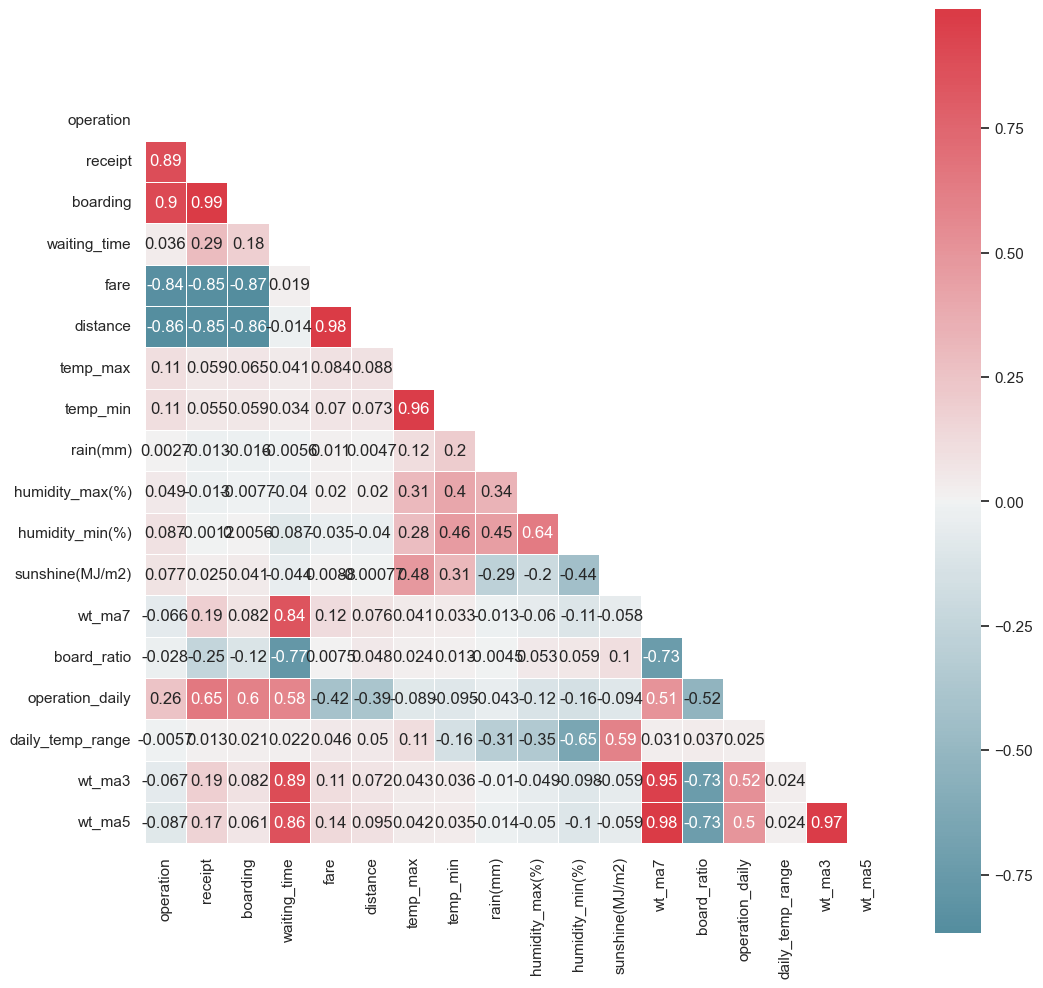

In [16]:
num_vars = ['operation', 'receipt', 'boarding', 'waiting_time', 'fare',
       'distance', 'temp_max', 'temp_min', 'rain(mm)', 'humidity_max(%)',
       'humidity_min(%)', 'sunshine(MJ/m2)', 'wt_ma7', 'board_ratio', 'operation_daily', 'daily_temp_range', 'wt_ma3', 'wt_ma5']

eda_2_corr(df, num_vars)

## 5. 데이터 전처리

In [17]:
# 가변수화
dumm_col = ['weekday', 'month', 'season', 'year', 'holiday', 'weekend', 'taxi_base_rate', 'covid', 'rain_yn']
df = pd.get_dummies(df, columns = dumm_col, drop_first = True, dtype = int)
df.head()

,Date,operation,receipt,boarding,waiting_time,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),wt_ma7,board_ratio,operation_daily,daily_temp_range,wt_ma3,wt_ma5,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,weekday_Saturday,weekday_Sunday,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,season_Summer,season_Fall,season_Winter,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,holiday_1.0,weekend_1,taxi_base_rate_3800,covid_1,rain_yn_1
0,2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,63.0,28.0,9.07,23.200,0.903226,4.802817,6.9,23.200000,23.200,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,2015-01-02,420,3158,2839,17.2,2216,8611,2.4,-9.2,0.0,73.0,37.0,8.66,20.200,0.898987,7.519048,11.6,20.200000,20.200,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2015-01-03,209,1648,1514,26.2,2377,10198,8.2,0.2,0.0,89.0,58.0,5.32,22.200,0.918689,7.885167,8.0,22.200000,22.200,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,2015-01-04,196,1646,1526,24.5,2431,10955,7.9,-0.9,0.0,95.0,52.0,6.48,22.775,0.927096,8.397959,8.8,22.633333,22.775,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,2015-01-05,421,4250,3730,26.2,2214,8663,4.1,-7.4,3.4,98.0,29.0,10.47,23.460,0.877647,10.095012,11.5,25.633333,23.460,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [18]:
# 데이터 분할
target = 'waiting_time'
x = df.drop(target, axis = 1)
y = df.loc[:, target]
x.shape, y.shape

((2923, 50), (2923,))

In [19]:
# train_set, test_set 분할
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                   test_size = 91,
                                                   shuffle = False,
                                                   random_state = 1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2832, 50), (91, 50), (2832,), (91,))

In [20]:
#  나중에 그래프에 Date 값을 포함하기 위함.
train_date = x_train.pop('Date')
test_date = x_test.pop('Date')

In [21]:
# 정규화 (KNN, SVM)
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)

##### 다중공선성 분석

In [22]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm import tqdm

In [26]:
vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(x_train.values, i) for i in tqdm(range(x_train.shape[1]))]
vif['Feature'] = x_train.columns


 10%|████████▍                                                                          | 5/49 [00:00<00:09,  4.88it/s]C:\Users\User\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:58<00:00,  1.19s/it]


In [27]:
vif = vif.sort_values(by='VIF_Factor', ascending=False).reset_index().drop(columns='index')
vif

,VIF_Factor,Feature
0,inf,daily_temp_range
1,inf,year_2019
2,inf,month_8
3,inf,weekday_Sunday
4,inf,weekday_Saturday
5,inf,month_9
6,inf,month_10
7,inf,month_11
8,inf,season_Summer
9,inf,season_Fall


In [ ]:
# 다중공선성 10 이상인 변수들이 많음.

## 6. 모델링

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# !pip install catboost
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [29]:
def pred_plot(y_val, pred, date):
    plt.figure(figsize = (18,6))
    sns.lineplot(x=date, y = y_val.values, label = 'actual value', marker = 'o')
    sns.lineplot(x=date, y = pred, label = 'predicted value', marker = 'o')
    plt.ylim(0,60)
    plt.grid()
    plt.show()

### (1) Linear Regression

In [30]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

result_MAE = {}
result_MAPE = {}
result_r2 = {}
result_MAE['Linear Regression'] = round(mean_absolute_error(y_test, y_pred), 3)
result_MAPE['Linear Regression'] = round(mean_absolute_percentage_error(y_test, y_pred), 3)
result_r2['Linear Regression'] = round(r2_score(y_test, y_pred), 3)

MAE: 3.10195732505976
MAPE: 0.07909203686431959
R2: 0.519594556230137


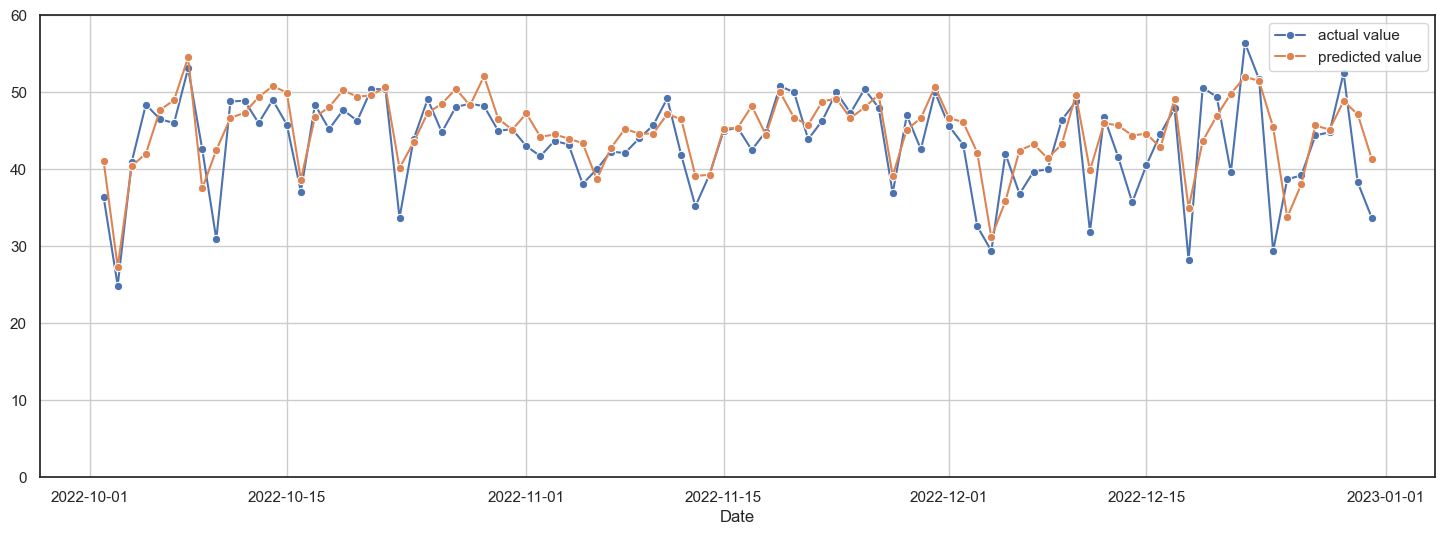

In [31]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
pred_plot(y_test, y_pred, test_date)

### (2) KNN Regressor

In [39]:
model = KNeighborsRegressor() # n_neighbors = 2
model.fit(x_train_s, y_train)
y_pred = model.predict(x_test_s)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

result_MAE['KNN'] = round(mean_absolute_error(y_test, y_pred), 3)
result_MAPE['KNN'] = round(mean_absolute_percentage_error(y_test, y_pred), 3)
result_r2['KNN'] = round(r2_score(y_test, y_pred), 3)

MAE: 6.902197802197801
MAPE: 0.15643747685309667
R2: -0.9292906729392165


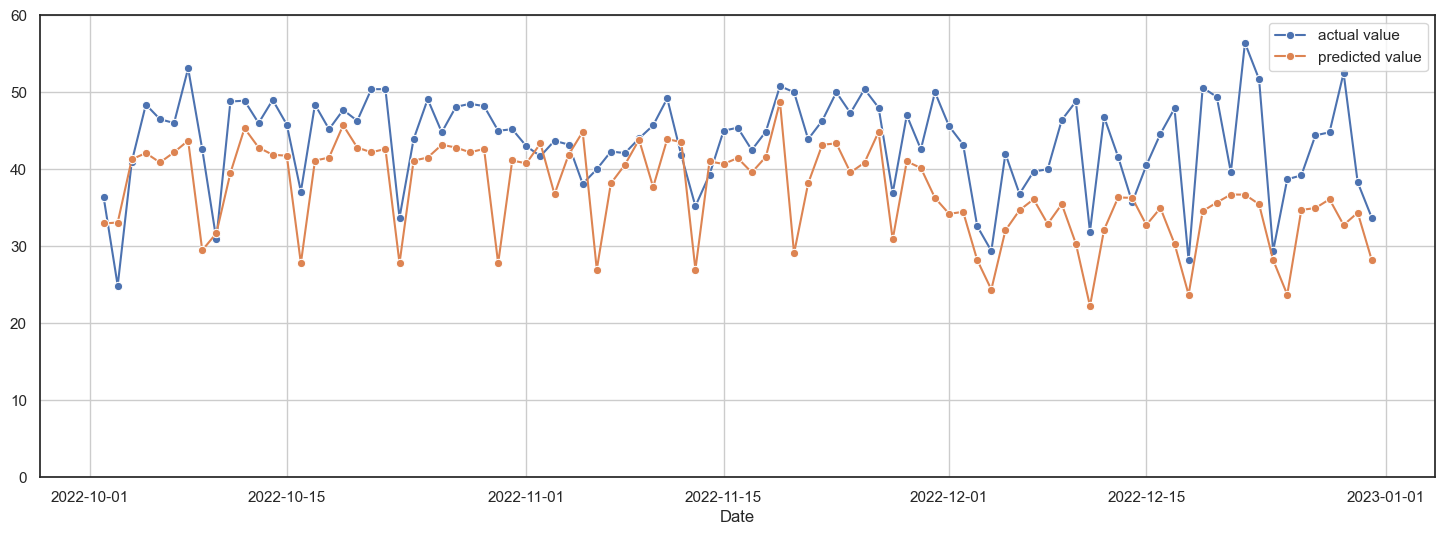

In [40]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
pred_plot(y_test, y_pred, test_date)

### (3) SVM (Regression)

In [41]:
model = SVR()
model.fit(x_train_s, y_train)
y_pred = model.predict(x_test_s)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

result_MAE['SVM'] = round(mean_absolute_error(y_test, y_pred), 3)
result_MAPE['SVM'] = round(mean_absolute_percentage_error(y_test, y_pred), 3)
result_r2['SVM'] = round(r2_score(y_test, y_pred), 3)

MAE: 3.5906142418357794
MAPE: 0.08299787302288648
R2: 0.4251330950690768


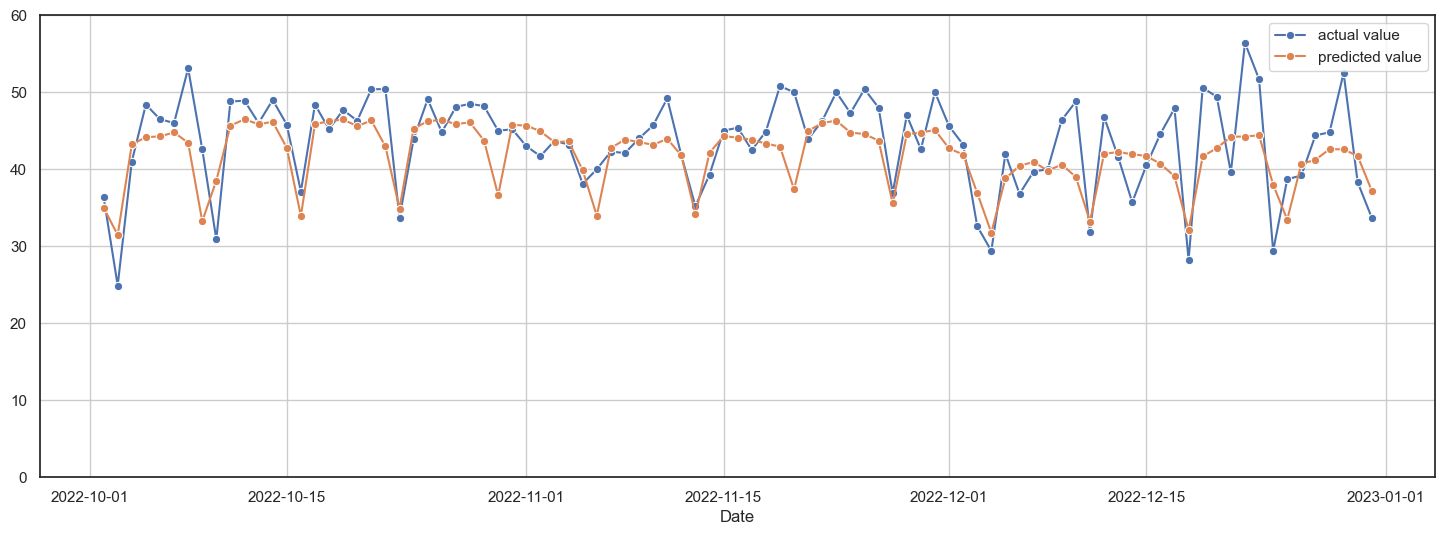

In [42]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
pred_plot(y_test, y_pred, test_date)

### (4) RandomForest

In [43]:
model = RandomForestRegressor(max_depth=5,
                              random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

result_MAE['RF'] = round(mean_absolute_error(y_test, y_pred), 3)
result_MAPE['RF'] = round(mean_absolute_percentage_error(y_test, y_pred), 3)
result_r2['RF'] = round(r2_score(y_test, y_pred), 3)

MAE: 2.9676662444026927
MAPE: 0.07380401442359409
R2: 0.5539255280419012


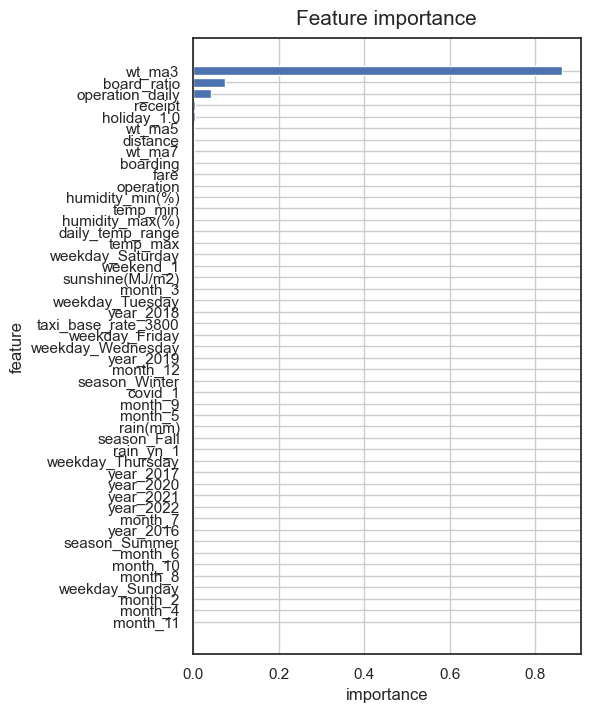

In [44]:
# 변수 중요도 시각화
df = pd.DataFrame()
df['feature'] = list(x_train)
df['importance'] = model.feature_importances_
df.sort_values(by='importance', ascending=True, inplace=True)

plt.figure(figsize=(5,8))
plt.barh(df['feature'], df['importance'])
plt.title("Feature importance", size =15, pad=10)
plt.xlabel("importance")
plt.ylabel("feature")
plt.grid()
plt.show()

  0%|                                                                                           | 0/49 [04:16<?, ?it/s]


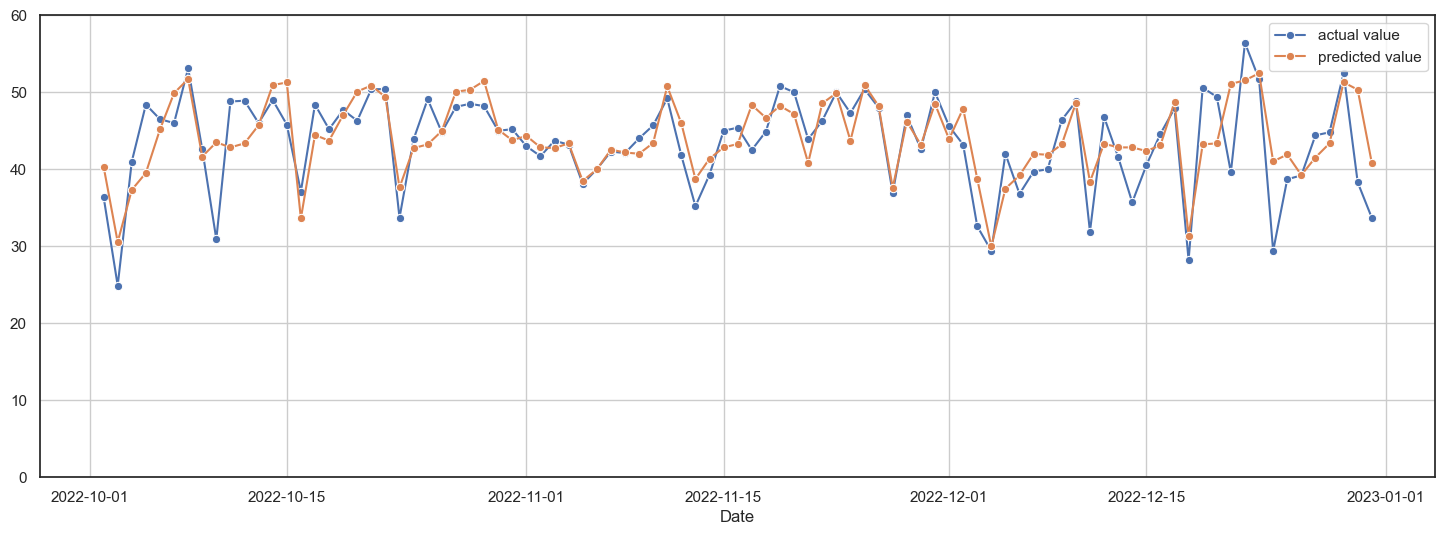

In [45]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
pred_plot(y_test, y_pred, test_date)

### (5) XGBoost

In [46]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
model = XGBRegressor(max_depth=15,
                              random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
result_MAE['XGB'] = round(mean_absolute_error(y_test, y_pred), 3)
result_MAPE['XGB'] = round(mean_absolute_percentage_error(y_test, y_pred), 3)
result_r2['XGB'] = round(r2_score(y_test, y_pred), 3)

MAE: 3.1112365890335245
MAPE: 0.07691045631786346
R2: 0.5093123575999216


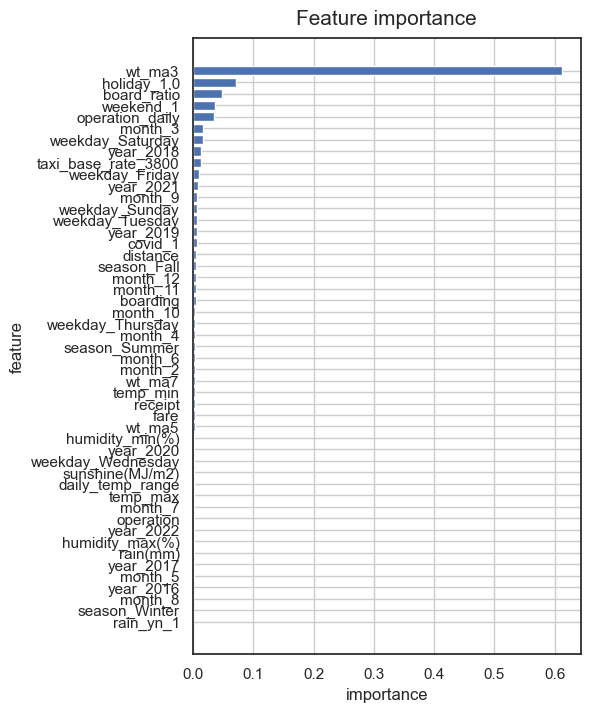

In [47]:
# 변수 중요도 시각화
df = pd.DataFrame()
df['feature'] = list(x_train)
df['importance'] = model.feature_importances_
df.sort_values(by='importance', ascending=True, inplace=True)


plt.figure(figsize=(5,8))
plt.barh(df['feature'], df['importance'])
plt.title("Feature importance", size =15, pad=10)
plt.xlabel("importance")
plt.ylabel("feature")
plt.grid()
plt.show()

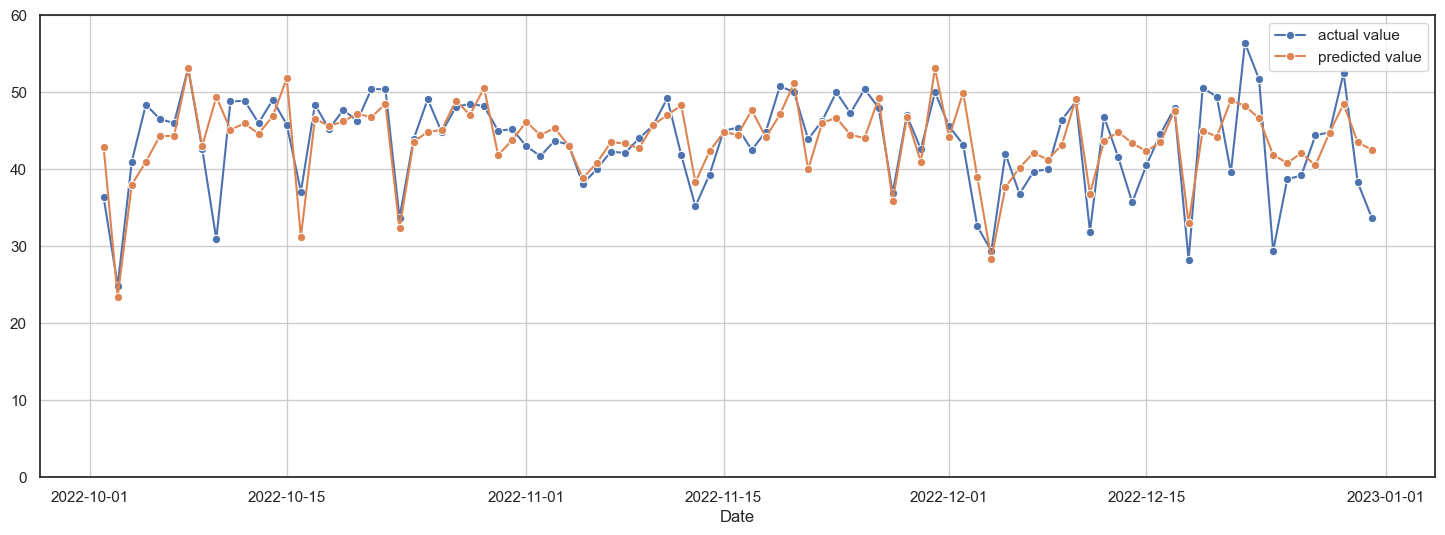

In [48]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
pred_plot(y_test, y_pred, test_date)

### LightGBM

In [49]:
model = LGBMRegressor(max_depth=10,
                      random_state=1,
                      verbose=-1)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
result_MAE['LGB'] = round(mean_absolute_error(y_test, y_pred), 3)
result_MAPE['LGB'] = round(mean_absolute_percentage_error(y_test, y_pred), 3)
result_r2['LGB'] = round(r2_score(y_test, y_pred), 3)

MAE: 3.3512479236803636
MAPE: 0.08028533623558108
R2: 0.5117778702882891


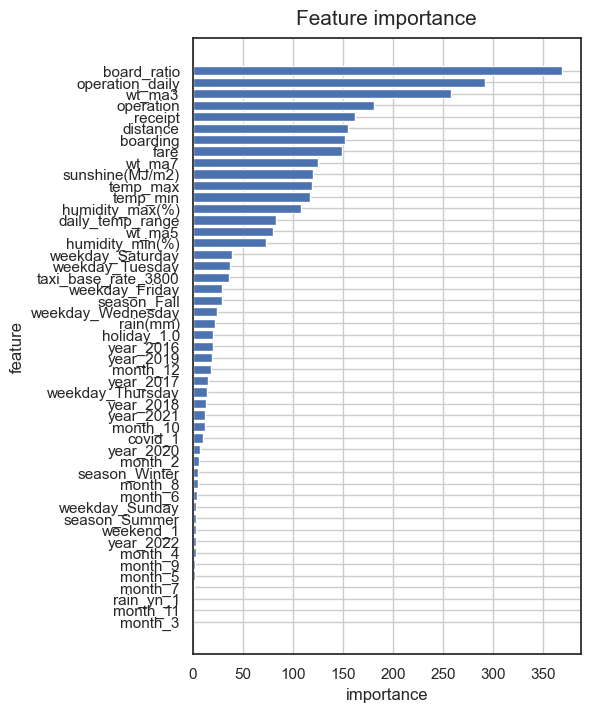

In [50]:
# 변수 중요도 시각화
df = pd.DataFrame()
df['feature'] = list(x_train)
df['importance'] = model.feature_importances_
df.sort_values(by='importance', ascending=True, inplace=True)


plt.figure(figsize=(5,8))
plt.barh(df['feature'], df['importance'])
plt.title("Feature importance", size =15, pad=10)
plt.xlabel("importance")
plt.ylabel("feature")
plt.grid()
plt.show()

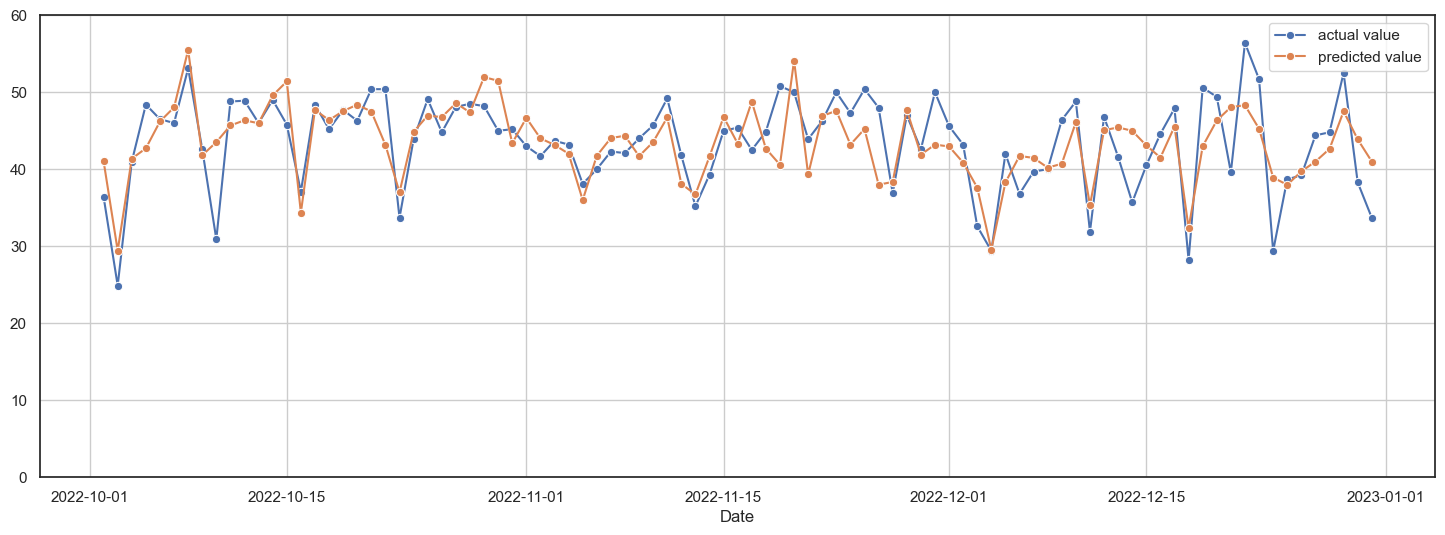

In [51]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
pred_plot(y_test, y_pred, test_date)

### (7) Catboost
https://catboost.ai/en/docs/concepts/python-reference_catboostregressor

In [78]:
model = CatBoostRegressor(max_depth=15,
                          random_state=1) # n_estimators 
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
result_MAE['catB'] = round(mean_absolute_error(y_test, y_pred), 3)
result_MAPE['catB'] = round(mean_absolute_percentage_error(y_test, y_pred), 3)
result_r2['catB'] = round(r2_score(y_test, y_pred), 3)

Learning rate set to 0.048263
0:	learn: 13.7679212	total: 1.87s	remaining: 31m 4s
1:	learn: 13.2643313	total: 1.87s	remaining: 15m 35s
2:	learn: 12.8232036	total: 6.65s	remaining: 36m 50s
3:	learn: 12.4274185	total: 10.5s	remaining: 43m 22s
4:	learn: 12.0142532	total: 15.3s	remaining: 50m 42s
5:	learn: 11.6242848	total: 17.3s	remaining: 47m 42s
6:	learn: 11.2740543	total: 21s	remaining: 49m 38s
7:	learn: 10.9362723	total: 26.2s	remaining: 54m 8s
8:	learn: 10.5936761	total: 30.4s	remaining: 55m 52s
9:	learn: 10.2663153	total: 33.9s	remaining: 56m
10:	learn: 9.9529270	total: 39.2s	remaining: 58m 41s
11:	learn: 9.6430218	total: 45.9s	remaining: 1h 3m 1s
12:	learn: 9.4059391	total: 51.8s	remaining: 1h 5m 34s
13:	learn: 9.1469466	total: 56.2s	remaining: 1h 6m 1s
14:	learn: 8.8878583	total: 1m 2s	remaining: 1h 8m 27s
15:	learn: 8.6653871	total: 1m 6s	remaining: 1h 8m 15s
16:	learn: 8.4285991	total: 1m 12s	remaining: 1h 9m 41s
17:	learn: 8.1958263	total: 1m 16s	remaining: 1h 9m 42s
18:	learn:


KeyboardInterrupt



In [ ]:
# 변수 중요도 시각화
df = pd.DataFrame()
df['feature'] = list(x_train)
df['importance'] = model.feature_importances_
df.sort_values(by='importance', ascending=True, inplace=True)


plt.figure(figsize=(5,8))
plt.barh(df['feature'], df['importance'])
plt.title("Feature importance", size =15, pad=10)
plt.xlabel("importance")
plt.ylabel("feature")
plt.grid()
plt.show()

In [ ]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
pred_plot(y_test, y_pred, test_date)

### (8) AdaBoostRegressor
-https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

In [52]:
model = AdaBoostRegressor(base_estimator=Lasso(),
                         random_state = 1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
result_MAE['AdaBoost'] = round(mean_absolute_error(y_test, y_pred), 3)
result_MAPE['AdaBoost'] = round(mean_absolute_percentage_error(y_test, y_pred), 3)
result_r2['AdaBoost'] = round(r2_score(y_test, y_pred), 3)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


MAE: 3.0520883393580527
MAPE: 0.07574780072893512
R2: 0.5843610620202863


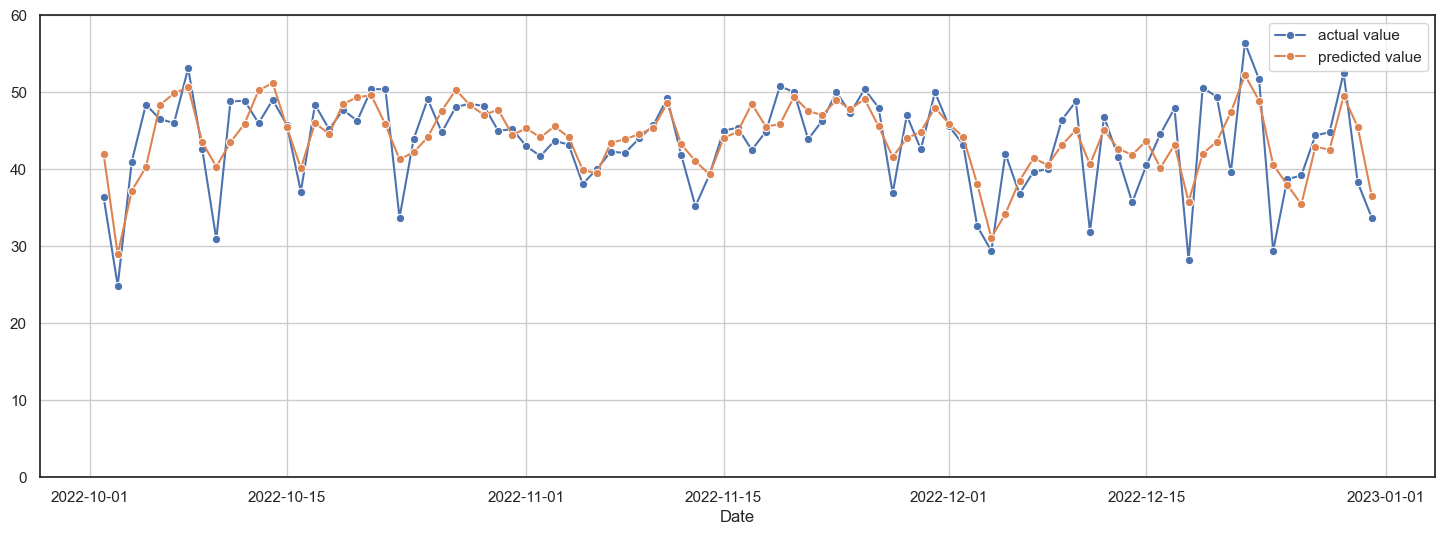

In [53]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
pred_plot(y_test, y_pred, test_date)

### (9) BaggingRegressor
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

In [54]:
model = BaggingRegressor(random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
result_MAE['BaggingRegressor'] = round(mean_absolute_error(y_test, y_pred), 3)
result_MAPE['BaggingRegressor'] = round(mean_absolute_percentage_error(y_test, y_pred), 3)
result_r2['BaggingRegressor'] = round(r2_score(y_test, y_pred), 3)

MAE: 3.4461538461538446
MAPE: 0.0825462513943778
R2: 0.46069021619684736


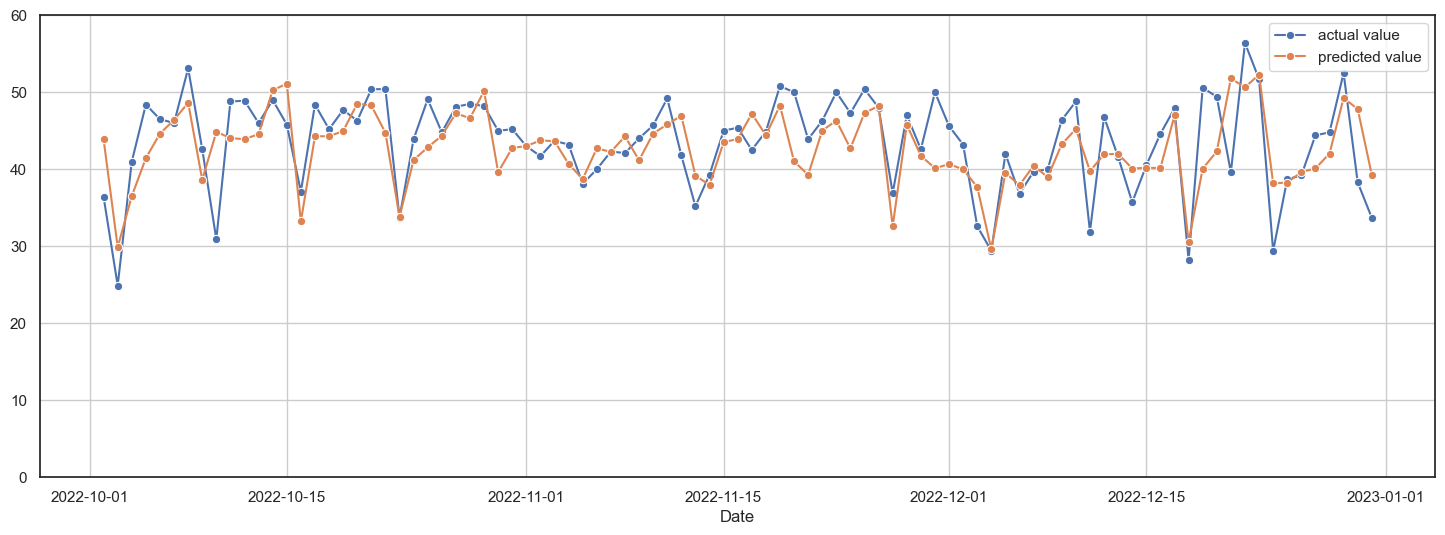

In [55]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
pred_plot(y_test, y_pred, test_date)

### (10) ExtraTreesRegressor
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

In [56]:
model = ExtraTreesRegressor(random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
result_MAE['ExtraTreesRegressor'] = round(mean_absolute_error(y_test, y_pred), 3)
result_MAPE['ExtraTreesRegressor'] = round(mean_absolute_percentage_error(y_test, y_pred), 3)
result_r2['ExtraTreesRegressor'] = round(r2_score(y_test, y_pred), 3)

MAE: 2.77551648351648
MAPE: 0.06757603694973727
R2: 0.6231401398456711


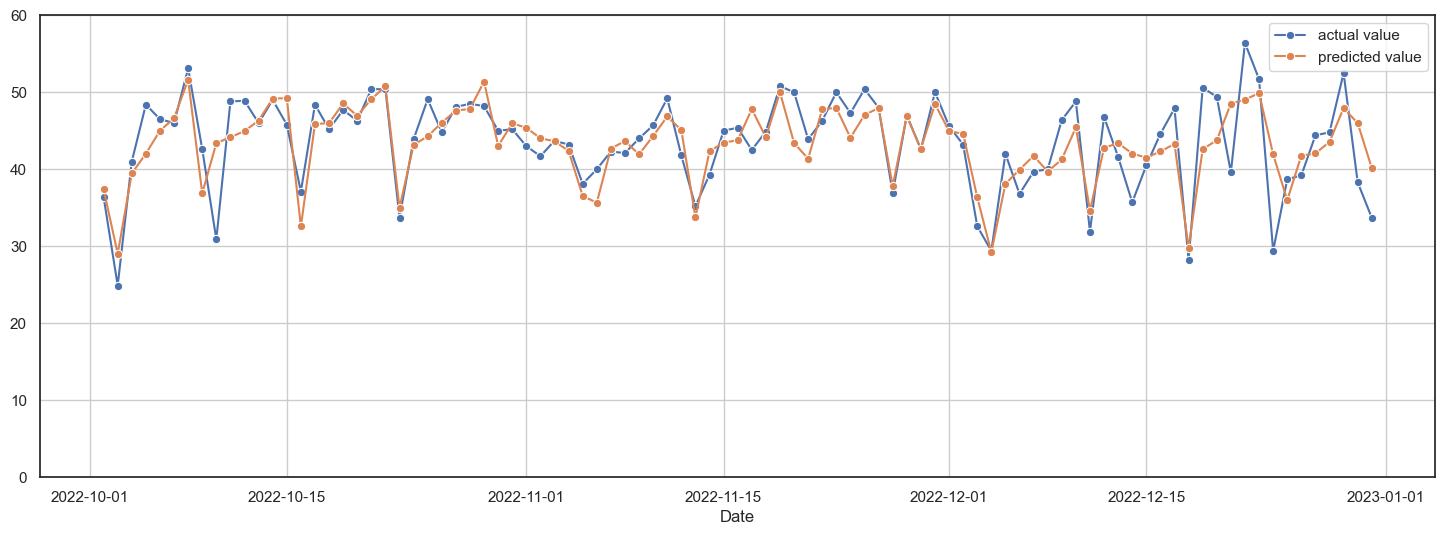

In [57]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
pred_plot(y_test, y_pred, test_date)

### (11) GraientBoostingRegressor
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

In [58]:
model = GradientBoostingRegressor(max_depth=15,
                                  random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
result_MAE['GradientBoostingRegressor'] = round(mean_absolute_error(y_test, y_pred), 3)
result_MAPE['GradientBoostingRegressor'] = round(mean_absolute_percentage_error(y_test, y_pred), 3)
result_r2['GradientBoostingRegressor'] = round(r2_score(y_test, y_pred), 3)

MAE: 3.5780369693515617
MAPE: 0.08906039981853414
R2: 0.2965745993673886


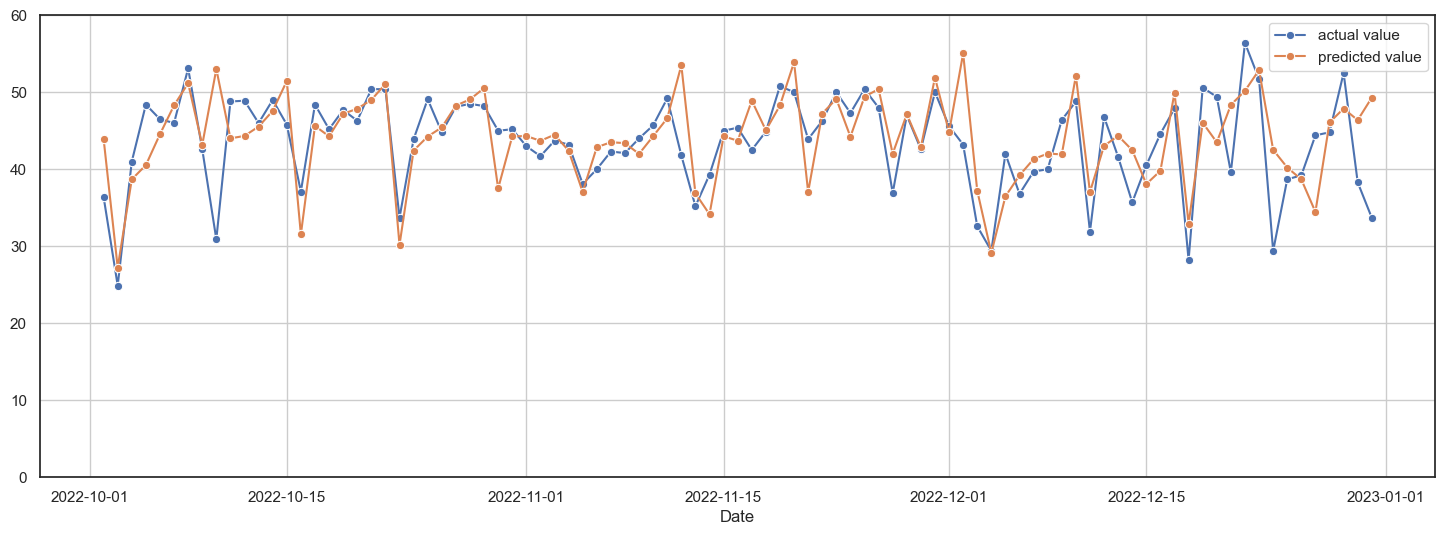

In [59]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
pred_plot(y_test, y_pred, test_date)

### (12) StackingRegressor
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html

In [60]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR

estimators = [('lr', RidgeCV()), 
              ('svr', LinearSVR(dual="auto", random_state=1))]

model = StackingRegressor(estimators=estimators,
                         final_estimator=RandomForestRegressor(n_estimators=10,
                                                              random_state=1))


model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
result_MAE['StackingRegressor'] = round(mean_absolute_error(y_test, y_pred), 3)
result_MAPE['StackingRegressor'] = round(mean_absolute_percentage_error(y_test, y_pred), 3)
result_r2['StackingRegressor'] = round(r2_score(y_test, y_pred), 3)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

MAE: 4.884505494505494
MAPE: 0.11740602413675309
R2: -0.06316164932838375


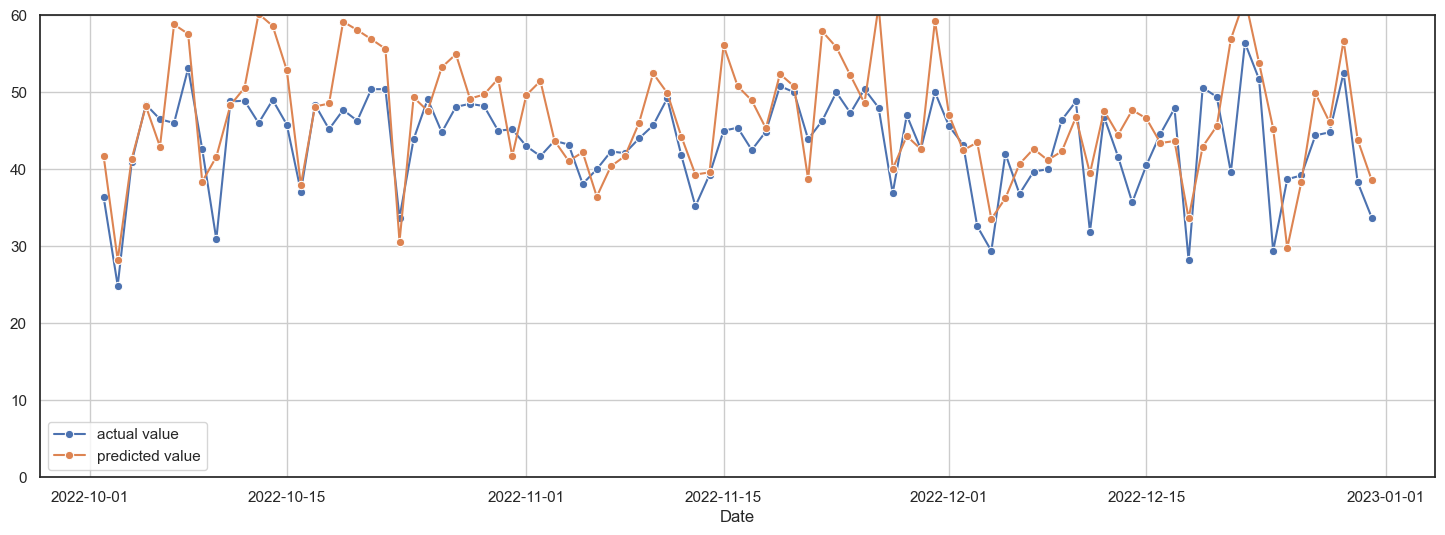

In [61]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
pred_plot(y_test, y_pred, test_date)

### (13) VotingRegressor
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html

In [62]:
from sklearn.ensemble import VotingRegressor
r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=10, random_state=1)
r3 = KNeighborsRegressor()

model = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
result_MAE['VotingRegressor'] = round(mean_absolute_error(y_test, y_pred), 3)
result_MAPE['VotingRegressor'] = round(mean_absolute_percentage_error(y_test, y_pred), 3)
result_r2['VotingRegressor'] = round(r2_score(y_test, y_pred), 3)

MAE: 2.7957722090067763
MAPE: 0.0693627537552767
R2: 0.6324134960281738


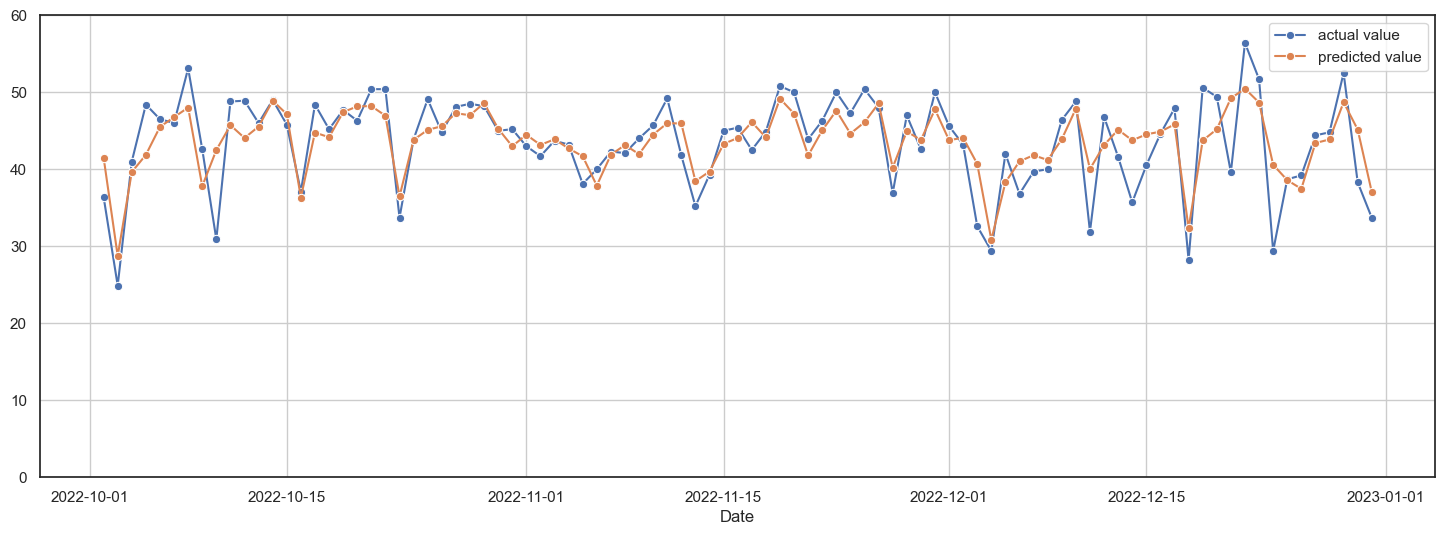

In [63]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
pred_plot(y_test, y_pred, test_date)

### (14) DecisionTree

In [64]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score,RandomizedSearchCV
model = DecisionTreeRegressor(max_depth=6,
                              random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
result_MAE['DecisionTreeRegressor'] = round(mean_absolute_error(y_test, y_pred), 3)
result_MAPE['DecisionTreeRegressor'] = round(mean_absolute_percentage_error(y_test, y_pred), 3)
result_r2['DecisionTreeRegressor'] = round(r2_score(y_test, y_pred), 3)

MAE: 4.206107643421908
MAPE: 0.1030744505721242
R2: 0.11994441094833508


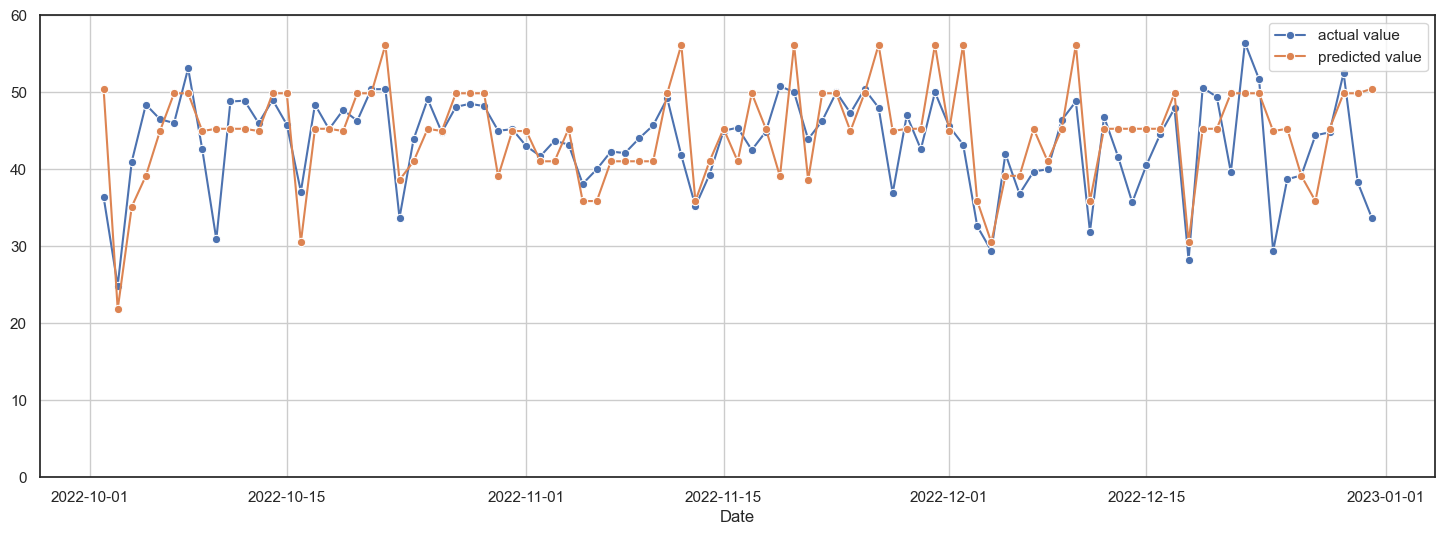

In [65]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.
pred_plot(y_test, y_pred, test_date)

## 7. 성능비교

MAE : 4 ~ 6  
MAPE : 0.09~0.14

In [66]:
# 성능 비교
print('=' * 40)
print('mean_absolute_error 성능비교')
for m_name, score in result_MAE.items():
    print(m_name, score.round(3))
print('=' * 40)

mean_absolute_error 성능비교
Linear Regression 3.102
KNN 6.902
SVM 3.591
RF 2.968
XGB 3.111
LGB 3.351
AdaBoost 3.052
BaggingRegressor 3.446
ExtraTreesRegressor 2.776
GradientBoostingRegressor 3.578
StackingRegressor 4.885
VotingRegressor 2.796
DecisionTreeRegressor 4.206


In [67]:
print('=' * 40)
print('mean_absolute_percentage_error 성능비교')
for m_name, score in result_MAPE.items():
    print(m_name, score.round(3))
print('=' * 40)

mean_absolute_percentage_error 성능비교
Linear Regression 0.079
KNN 0.156
SVM 0.083
RF 0.074
XGB 0.077
LGB 0.08
AdaBoost 0.076
BaggingRegressor 0.083
ExtraTreesRegressor 0.068
GradientBoostingRegressor 0.089
StackingRegressor 0.117
VotingRegressor 0.069
DecisionTreeRegressor 0.103


In [68]:
print('=' * 40)
print('R2-score 성능비교')
for m_name, score in result_r2.items():
    print(m_name, score.round(3))
print('=' * 40)

R2-score 성능비교
Linear Regression 0.52
KNN -0.929
SVM 0.425
RF 0.554
XGB 0.509
LGB 0.512
AdaBoost 0.584
BaggingRegressor 0.461
ExtraTreesRegressor 0.623
GradientBoostingRegressor 0.297
StackingRegressor -0.063
VotingRegressor 0.632
DecisionTreeRegressor 0.12


# 최종 결과
- Feature 수 : 50개
    - 파생변수 : 날짜(요일, 월, 계절, 연도), 공휴일, 3,5,7일 이동평균 대기시간, 탑승률, 하루에 처리해야할 차량 접수건수, 일교차, 주말, 택시 기본요금, 코로나유무, 강수유무
- VotingRegressor (LinearRegression, RandomForest, KNN 보팅)
    - MAE : 2.796
    - MAPE : 0.069
    - R2-score : 0.632

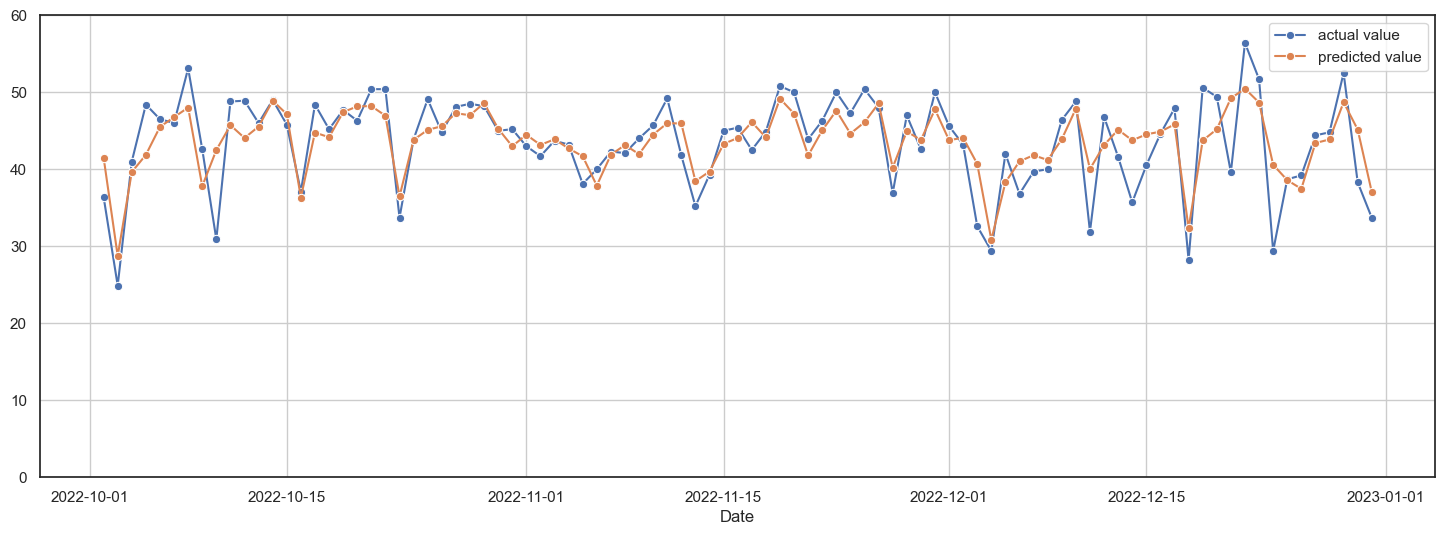

In [63]:
# 예측

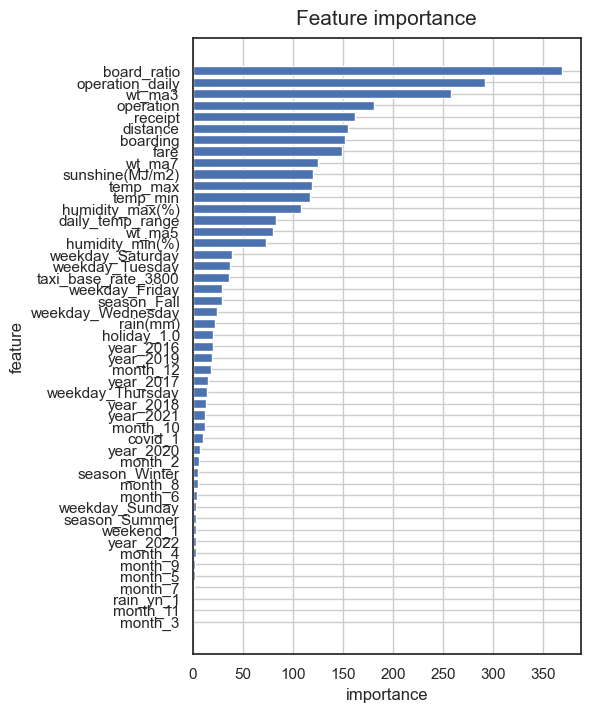

In [50]:
# 변수 중요도 시각화

-----

# 팀원결과

### (1) 팀원
- Feature 수 : 20개
    - 파생변수 : 강한비, 최저온도 영하, 최고온도 31도 초과, 코로나유무, 4일치 평균 거리, 주말
    - 제거변수 : 주차, 월, 년, 일사량, 습도, 강수량
- LinearRegression
    - MAE : 3.08
    - MAPE : 0.075
    - R2-score : 0.597

### (2) 팀원
- Feature 수 : 39개
    - 파생변수 : 날짜(요일, 월, 계절, 연도), 공휴일, 3,5,7,10,20,60,120일 이동평균 대기시간, 탑승률, 차량 1대 당 처리해야할 접수 건수, 일교차, 접수건수-탑승건수
- LinearRegression
    - MAE : 3.020
    - MAPE : 0.0765
    - R2-score : 0.5614

### (3) 팀원
- Feature 수 : 50개
    - 파생변수 :  날짜(요일, 월, 계절, 연도), 공휴일, 3,5,7일 이동평균 대기시간, 탑승률, 하루에 처리해야할 차량 접수건수, 일교차, 주말, 택시 기본요금, 코로나유무, 강수유무
- VotingRegressor (선형회귀, 릿지, 라쏘회귀, RandomForest, LGBM, XGBoost 보팅)
    - MAE : 2.792
    - MAPE : 0.069
    - R2-score : 0.608

### (4) 팀원
- Feature 수 : 17개
    - 파생변수 : 강한비, 코로나유무, 4일치 평균 거리, 주말
    - 제거변수 : 주차, 월, 년, 일사량, 습도, 강수량, 탑승건
- ExtraTreesRegressor (선형회귀, 릿지, 라쏘회귀, RandomForest, LGBM, XGBoost 보팅)
    - MAE : 3.00
    - MAPE : 0.070
    - R2-score : 0.604

# 참고사항(데이터 인사이트 분석)

[논의사항]
1) 차량운행 수가 어느 월에 가장 많은지
 - 11월이 대채로 많으며 (가을에 분포되어있다. 공휴일이 없기 때문에 차량운행 수가 많을 것이다.)
 - 공휴일이 없는 월 : 7월, 11월(공휴일x - 248/240건) 

2) 하루에 처리해야할 접수건수(파생변수: 접수건/차량운행수)가 가을에 왜 낮은지
 - r = 0.58 (한 차량당 처리해야할 건수가 많기 때문에, 평균대기시간이 길것이다.)
 - 9월달이 가장 차량건수가 적고, 모든 해가 그렇진 않다. 

3) 다른 교통수단에 따른 택시 접수율도 확인에 볼 필요도 있음. (아래)
 - 공휴일에 타 대중교통 운행이 적어지기 떄문에 택시타는 비율이 많아질 것이다.

4) 차량운행 값이 왜 매일마다 다른지
 - 차가 밀리는지 안밀리는지 따라 달라질 수 있다. (7km 반경이 넘어가면, 대기번호가 밀려 접수건수가 높아도 탑승건수가 적을것이다.)

5) 한해의 차량 평균대기시간이 12월에 도달할수록 커지는지
 - 운행횟수 대비 접수건이 많아져서 증가하는 양상을 보임.

6) 평균 대기시간이 이상치에 해당하는 경우에 어떤 특징이 있는지 살펴보는 것도 좋을 것 같습니다!
 - 4)항목과 동일하게 접수건에 영향을 많이 받있을 것이다.

* 추가 인사이트
- 탑승률이 주말에 낮은 이유 : 병원, 복지관을 평일에 간다 
- 2020년도 코로나로 인해 차량운행수, 접수건, 운행건이 줄다가 23년 이후로 증가함.
- 2020년도 차량운행수 증가 (정책변경)
- 주말에는 이동거리가 늘어나서 비용이 올라간다.
- 이동거리가 짧아지는대 평균대기시간은 길어진다(겨울에는 운행수가 상대적으로 적다.)
- 가을의 평균대기시간이 길다 (공휴일이 가장 많고, 공휴일의 타 대중교통 운행이 적어지기 때문에 택시타는 비율이 많아질 것이다.)


- 날씨데이터는 평균대기시간과의 관계가 작다.
	- 습도가 높을때, 택시 탑승률이 높다. (시각화)
	- 강수량과의 택시운행데이터 통계분석 시 접수건과 가장 유의미하였다 (pvalue<0.2)
	- temp_max와 평균대기시간 차이가 있을것이다.  (p-value 0.026)) (* 최저온도 영하일때, p-value 0.003)
 	- 일교차(temp_max - temp_min)는 상관계수 r =0.022 두 변수의 관계가 적다.

[참고문헌]
http://www.kpaj.or.kr/_PR/view/?aidx=36018&bidx=3230